<a href="https://colab.research.google.com/github/Jaskaran7d5/week1/blob/main/week3task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

dataset_url = 'http://d2l-data.s3-accelerate.amazonaws.com/pokemon.zip'
od.download(dataset_url)

Using downloaded and verified file: ./pokemon.zip


In [3]:

from zipfile import ZipFile
with ZipFile('/content/pokemon.zip','r') as obj:
  obj.extractall('/content/')

In [4]:
import os
import cv2
images=list()
# Assign directory
directory = r"/content/pokemon"

# Iterate over files in directory
for fold in os.listdir(directory):
    # Open file
    for img in os.listdir(directory+'/'+fold):
     ii = cv2.imread(directory+'/'+fold+'/'+img)
     images.append(ii)

In [5]:
for i in range(len(images)):
  images[i]= cv2.resize(images[i], (64,64), interpolation = cv2.INTER_LINEAR)

In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
train_dl = DataLoader(images,256, shuffle=True, pin_memory=True)

In [7]:
sample = next(iter(train_dl))

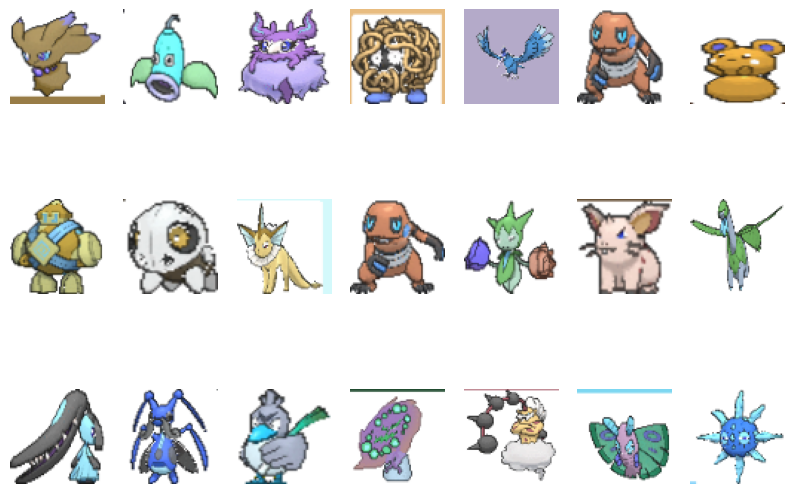

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 7))

for i in range(0,21):
    fig.add_subplot(3, 7, i+1)
    plt.imshow(sample[i])
    plt.axis('off')

In [9]:
import torch
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = torch.device('cuda')
train_dl = DeviceDataLoader(train_dl, device)

In [10]:
import torch.nn as nn
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [11]:
discriminator = to_device(discriminator, device)

In [12]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [13]:
generator = to_device(generator, device)

In [14]:
batch_size = 256
import torch.nn.functional as F
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(((real_images.resize(256,3,64,64))*255/255).to('cuda'))
    real_targets = torch.ones(real_images.size(0), 1,device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1,device = device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1,device = device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [15]:
import torch
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1,device = device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1,device = device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [16]:
fixed_latent = torch.randn(64, latent_size, 1, 1,device = device)

In [17]:
generator(fixed_latent).shape

torch.Size([64, 3, 64, 64])

In [18]:
from tqdm.notebook import tqdm
epoch_lists = list()
def fit(epochs, lr, start_idx=1):


    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images in tqdm(train_dl):
            # Train discriminator
            #print(real_images.shape)
            try:
              loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
              loss_g = train_generator(opt_g)
            except:
              continue

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        fake_images = generator(fixed_latent)
        epoch_lists.append(fake_images)
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images

    return losses_g, losses_d, real_scores, fake_scores

In [19]:
lg,ld,rs,fs=fit(7,0.0002)

  0%|          | 0/159 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:893: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch [1/7], loss_g: 5.5550, loss_d: 0.2838, real_score: 0.8839, fake_score: 0.1259


  0%|          | 0/159 [00:00<?, ?it/s]

Epoch [2/7], loss_g: 4.9919, loss_d: 0.6346, real_score: 0.6157, fake_score: 0.0096


  0%|          | 0/159 [00:00<?, ?it/s]

Epoch [3/7], loss_g: 6.1552, loss_d: 1.1353, real_score: 0.9176, fake_score: 0.5931


  0%|          | 0/159 [00:00<?, ?it/s]

Epoch [4/7], loss_g: 5.9336, loss_d: 0.9823, real_score: 0.9724, fake_score: 0.5842


  0%|          | 0/159 [00:00<?, ?it/s]

Epoch [5/7], loss_g: 3.0811, loss_d: 0.3259, real_score: 0.8142, fake_score: 0.0974


  0%|          | 0/159 [00:00<?, ?it/s]

Epoch [6/7], loss_g: 3.9635, loss_d: 0.3182, real_score: 0.9044, fake_score: 0.1812


  0%|          | 0/159 [00:00<?, ?it/s]

Epoch [7/7], loss_g: 7.2457, loss_d: 1.7447, real_score: 0.9974, fake_score: 0.7695


In [22]:
first = epoch_lists[0].detach().cpu().numpy()

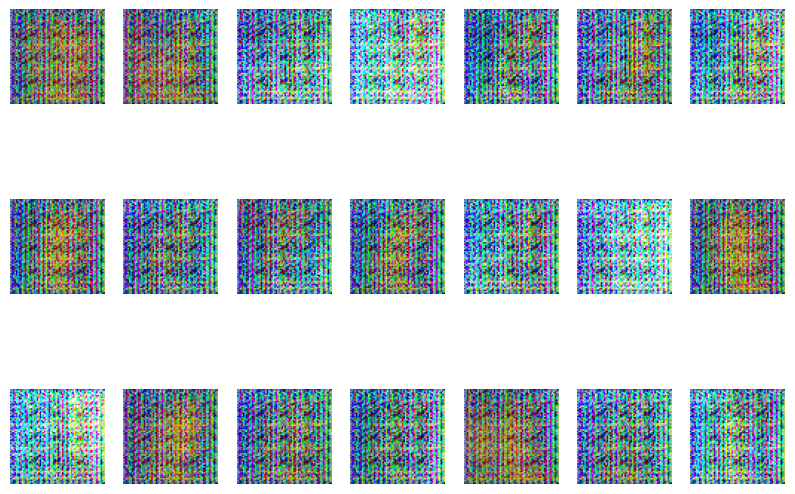

In [25]:
fig = plt.figure(figsize=(10, 7))

for i in range(0,21):
    fig.add_subplot(3, 7, i+1)
    plt.imshow(first[i].T)
    plt.axis('off')

In [26]:
thala = epoch_lists[6].detach().cpu().numpy()

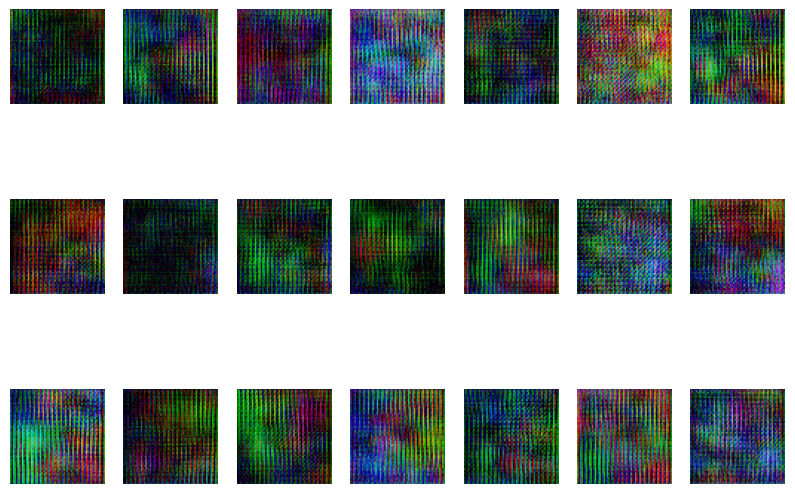

In [27]:
fig = plt.figure(figsize=(10, 7))

for i in range(0,21):
    fig.add_subplot(3, 7, i+1)
    plt.imshow(thala[i].T)
    plt.axis('off')